# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [81]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.decomposition import PCA


# Classifiers
from worclipo.load_data import load_data

### functions

In [82]:
# function to split the dataset into train and test
def split_set(X,y,test_size):

    if os.path.exists('./TEST_set.csv'):
        split_action = print('TEST_set.csv already exists')
    else:
        split_action = print('TEST_set.csv does not exist, generating new test and training sets')
        X_train_csv, X_test_csv, y_train_csv, y_test_csv = train_test_split(X, y, test_size=test_size, random_state=10)

        TESTSET = X_test_csv.merge(y_test_csv, left_index=True, right_index=True)
        TESTSET.to_csv('TEST_set.csv')

        TRAINSET = X_train_csv.merge(y_train_csv, left_index=True, right_index=True)
        TRAINSET.to_csv('TRAIN_set.csv')
        return split_action
    

# setting up the data to be processed

In [83]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(type(data))

# change lipoma = 1 and liposarcoma = 0 and encode labels
group_names = list(set(data.label))
data.loc[data['label'] == 'lipoma', 'label'] = 1
data.loc[data['label'] == 'liposarcoma', 'label'] = 0
data['label'] = pd.cut(data['label'], bins = 2, labels=group_names)
print(data['label'].unique())
label_diag = LabelEncoder()
data['label'] = label_diag.fit_transform(data['label'])

# assign X to measurements and y to outcome (lipoma/sarcoma)
X = data.drop('label', axis=1)
y = data['label']
test_size = 0.3

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
['liposarcoma', 'lipoma']
Categories (2, object): ['liposarcoma' < 'lipoma']


In [84]:
# code that splits the data into test and validation sets if this is not done already
split_set(X,y,test_size)

TEST_set.csv already exists


## import the training set

In [85]:
TRAIN = pd.read_csv('TRAIN_set.csv', index_col=0)
X_train = TRAIN.drop('label', axis=1)
y_train = TRAIN['label']

TRAIN['label'] = pd.cut(TRAIN['label'], bins = 2, labels=group_names)
print(TRAIN['label'].unique())
label_diag = LabelEncoder()
TRAIN['label'] = label_diag.fit_transform(TRAIN['label'])

# split into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=10)

print(f'Size before preprocess: ', X_train.shape)

clf_1 = Pipeline([('PCA', PCA()),
                ('SVC', SVC(kernel='sigmoid', probability=True, random_state=1))
                ])

# set this to 0 if you want to check which n components is best
PCA_components = 19

if PCA_components == 0:
    X_train_PCA = X_train
    X_valid_PCA = X_valid
    y_train_PCA = y_train
    y_valid_PCA = y_valid

    pipe_PCA = Pipeline([
        ("check nan", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("scale", StandardScaler()),
        ("variance", VarianceThreshold(threshold=0)) 
    ]) 

    X_train_PCA = pipe_PCA.fit_transform(X_train_PCA)

    # grid search for optimal n
    gsf = GridSearchCV(
        clf_1, 
        {'PCA__n_components' : [v for v in np.arange(15,30)],
        'SVC__C' : [24]},
        ).fit(X_train_PCA, y_train_PCA)
    print(gsf.best_params_)

    # apply this n to the dataset
    pipe_preprocess = Pipeline([
        ("PCA", PCA(n_components=gsf.best_params_['PCA__n_components']))   
    ]) 
   
    X_train = pipe_preprocess.fit_transform(X_train, y_train)
    X_valid = pipe_preprocess.transform(X_valid)

else: 
    # apply n_components to dataset
    pipe_preprocess = Pipeline([
        ("check nan", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("scale", StandardScaler()),
        ("variance", VarianceThreshold(threshold=0)),
        ("PCA", PCA(n_components=PCA_components))   
    ]) 

    X_train = pipe_preprocess.fit_transform(X_train, y_train)
    X_valid = pipe_preprocess.transform(X_valid)


print(f'Size after n_components PCA: ', X_train.shape)


['liposarcoma', 'lipoma']
Categories (2, object): ['liposarcoma' < 'lipoma']
Size before preprocess:  (56, 493)
Size after n_components PCA:  (56, 19)


# Classify

In [86]:
# setup classifiers
clf1 = RandomForestClassifier(random_state=1)
clf2 = SVC(probability=True, random_state=1)
clf3 = LogisticRegression(random_state=1)
clf4 = DecisionTreeClassifier(random_state=1)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()

# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [1,10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [22]
param2['classifier__class_weight'] = [None]
param2['classifier__kernel'] = ['sigmoid']
param2['classifier'] = [clf2]


param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = [None, 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]


pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4, param5, param6]
gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
print(gs.best_params_)

# results = pd.DataFrame(gs.best_params_)
# results = results.sort_values(by=['rank_test_score'])
# results.to_csv('results')

# Test data performance
print("Test Precision:",precision_score(gs.predict(X_valid), y_valid))
print("Test Recall:",recall_score(gs.predict(X_valid), y_valid))
print("Test ROC AUC Score:",roc_auc_score(gs.predict(X_valid), y_valid))


0.8100000000000002
Pipeline(steps=[('classifier',
                 LogisticRegression(C=10, class_weight={0: 1, 1: 5},
                                    random_state=1))])
{'classifier': LogisticRegression(C=10, class_weight={0: 1, 1: 5}, random_state=1), 'classifier__C': 10, 'classifier__class_weight': {0: 1, 1: 5}, 'classifier__penalty': 'l2'}
Test Precision: 0.6923076923076923
Test Recall: 0.6923076923076923
Test ROC AUC Score: 0.6643356643356644


c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 785.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "c:\Users\kiki6\miniconda3\lib\s

gsb = GridSearchCV(
    estimator=SVC(probability=True,random_state=8,max_iter=1000),
    param_grid={'kernel':['linear','rbf','polynomial','sigmoid'],'C':[v for v in np.linspace(1,100,100)]},
    cv = 5,
    n_jobs=-1,
    scoring= 'recall').fit(X_train,y_train)

print(gsb.best_params_)
print(gsb.best_estimator_)

best_clf = gsb.best_estimator_
best_clf.fit(X_train,y_train)
pred_rfc = best_clf.predict(X_valid)

print('rfc', classification_report(y_valid, pred_rfc))
print(confusion_matrix(y_valid, pred_rfc))


results = pd.DataFrame(gsb.cv_results_)
results = results.sort_values(by=['rank_test_score'])
results.to_csv('results')

print("Test Precision:",precision_score(gsb.predict(X_valid), y_valid))
print("Test Recall:",recall_score(gsb.predict(X_valid), y_valid))
print("Test ROC AUC Score:",roc_auc_score(gsb.predict(X_valid), y_valid))


### Cross validation K-fold test

The best k-fold value for LogisticRegression is 8 with a mean accuracy of 0.679
The best k-fold value for DecisionTreeClassifier is 9 with a mean accuracy of 0.730
The best k-fold value for RandomForestClassifier is 11 with a mean accuracy of 0.658
The best k-fold value for KNeighborsClassifier is 12 with a mean accuracy of 0.629
The best k-fold value for SVC is 7 with a mean accuracy of 0.643


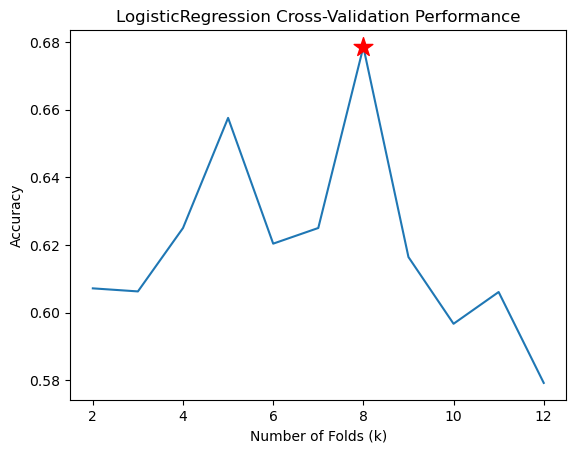

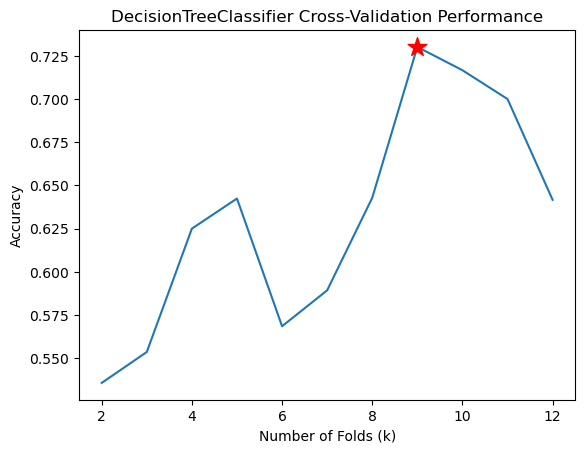

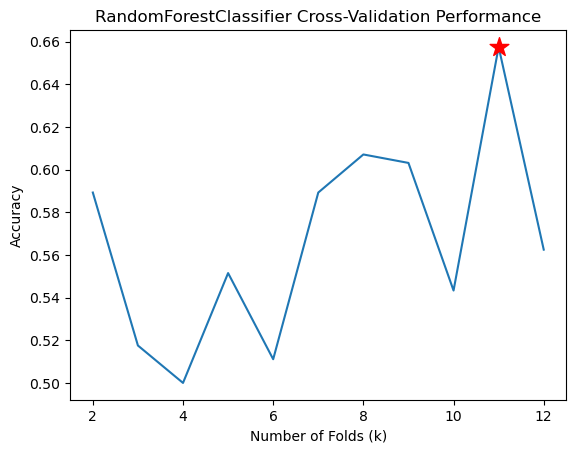

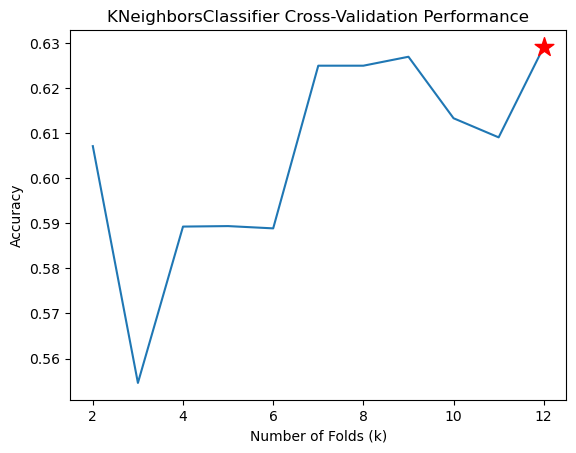

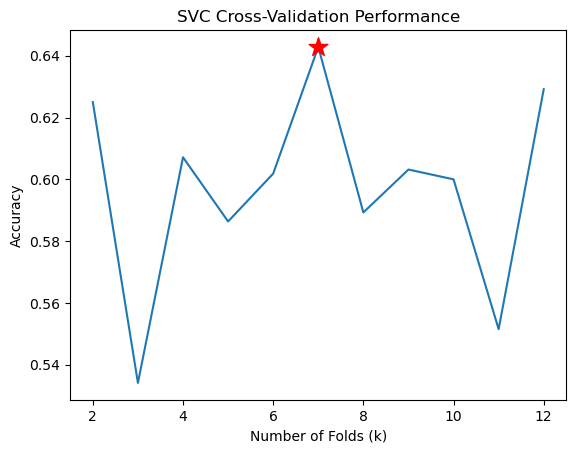

In [107]:

# Trying differen K folds in cross validation per classifier
# (Since shuffle is true, answers for best k value might vary)
# Used to give us an idea on which Kfold to use

# function
def perform_cross_validation(clf, k_values, X_train, y_train):
    best_k = None
    best_score = None
    results = []
    for k in k_values:
        kf = KFold(n_splits=k, shuffle=True, random_state=10)
        scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
        mean_score = np.mean(scores)
        results.append((k, scores))
        if best_score is None or mean_score > best_score:
            best_k = k
            best_score = mean_score
    return best_k, results

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC()
]

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

best_k_values = {}
results = []

for clf in classifiers:
    clf_name = type(clf).__name__
    best_k, cv_results = perform_cross_validation(clf, k_values, X_train, y_train)
    best_k_values[clf_name] = best_k
    results.append((clf_name, cv_results))
    print(f"The best k-fold value for {clf_name} is {best_k} with a mean accuracy of {np.max([np.mean(cv_scores) for _, cv_scores in cv_results]):.3f}")

for clf_name, cv_results in results:
    fig, ax = plt.subplots()
    scores = [np.mean(cv_scores) for _, cv_scores in cv_results]
    ax.plot(k_values, scores)
    ax.scatter(best_k_values[clf_name], np.max(scores), marker='*', s=200, color='r', zorder=10)
    ax.set_xlabel('Number of Folds (k)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{clf_name} Cross-Validation Performance')
    plt.show()